### ⚠ IMPORTANT ⚠

You will need at least 15GB of VRAM (GPU RAM) to run this notebook.

If you're running this locally - please ensure you have the correct hardware to support the fine-tuning.

# Task Fine-tuning a GPT-style model using `peft`, `transformers` and `bitsandbytes`

In the following notebook, we'll task fine-tune a GPT-style model on the summarization task using:

- [QLoRA](https://arxiv.org/pdf/2305.14314.pdf)/[LoRA](https://arxiv.org/pdf/2106.09685.pdf)

The basic idea is that we will fine-tune an "adapter" which will represent a small subset of trainable weights on our task. This will allow us to instruct-tune a comparitively large model with consumer level resources.

The model we'll be instruct-tuning today is [`NousResearch/Meta-Llama-3-8B-Instruct`](https://huggingface.co/NousResearch/Meta-Llama-3-8B-Instruct)!

> NOTE: The official Llama 3 weights are gated behind a EULA - while using the NousResearch version does not change the acceptable use of the model, it does shortcut needing to wait for the EULA to be accepted.

### Homework Sections

The notebook will be broken into the following sections:

1. Breakout Room #1:
  - Task #1: Loading the Model
2. Breakout Room #2:
  - Task #2: Data and Data Prep.
  - Task #3: Setting up PEFT LoRA
  - Task #4: Training the Model
  - Task #5: Share Your Model!

There are a total of 6 Questions, and 1 Activity, all of which must be completed to receive full marks for the homework.


#### ❓Question #1:

What makes Llama 3 8B Instruct a good model to use for a summarization task?

##### 🚀 Answer to Question #1 (I researched on you.com)

The Llama 3 8B Instruct model is particularly well-suited for summarization tasks due to several key features that enhance its performance in generating concise and coherent summaries.

- Multilingual Capabilities: Llama 3 8B Instruct is designed to handle multiple languages effectively.

- Optimized for Instruction-Following: This model is specifically optimized for following instructions, which is crucial for tasks like summarization where the model needs to understand and execute specific directives regarding the content.

- Extended Context Handling: The model is capable of processing extended contexts, allowing it to consider more information from the source text when generating summaries.



### Overview of PEFT and LoRA:

Based on some awesome research [here](https://github.com/huggingface/peft), we can leverage techniques like PEFT and LoRA to train/fine-tune large models a lot more efficiently.

It can't be explained much better than the overview given in the above link:

```
Parameter-Efficient Fine-Tuning (PEFT) methods enable efficient adaptation of
pre-trained language models (PLMs) to various downstream applications without
fine-tuning all the model's parameters. Fine-tuning large-scale PLMs is often
prohibitively costly. In this regard, PEFT methods only fine-tune a small
number of (extra) model parameters, thereby greatly decreasing the
computational and storage costs. Recent State-of-the-Art PEFT techniques
achieve performance comparable to that of full fine-tuning.
```

# 🤝 Breakout Room #1

### Setting Up Dependencies

We'll start by setting up the dependencies!

In [2]:
!pip install -qU bitsandbytes datasets accelerate loralib peft transformers trl

We'll first verify we're in a GPU instance.

In [5]:
import torch
if torch.cuda.is_available():
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name())

1
NVIDIA GeForce RTX 4060 Ti


Time to import some dependencies!

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig

## Task #1: Loading the Model

In the following task you will be expected to load the model from Hugging Face.

### Overview of Quantization:

Quantization is ultimately a simple concept with some very clever and tricky techniques that power it.

In today's notebook, we'll be exclusively focusing on the `bitsandbytes` quantization strategy which includes the idea of `k-bit` training.

Let's look at the QLoRA paper's definition of quantization:


```
Quantization is the process of discretizing an input from a representation that
holds more information to a representation with less information
```

Easy enough then!

Let's take a look at what that actually means.

### Block-wise k-bit Quantization

Ultimately, the QLoRA paper relies on a very specific form of quantization that relies on a few key ideas:

1. Model weights are mostly normally distributed
2. NF4 is a information-theoretically optimal data-type (this was later found to be [untrue](https://x.com/Tim_Dettmers/status/1668649436724199425?s=20), but NF4 is close to *empirically* optimal)


Let's think about quantization from a very high level - and use some oversimplifications to understand what's really happening under the hood.

In essence, we can think of quantization as placing a pin on the number line (our quantization constant) and then expressing a low-precision zero-centered size-64 block range around that pinned number. Exploiting the fact that our weights are normally distributed and that we scale them to be in the range [-1, 1], this lets use use our NF4 datatype to roughly optimally express our high precision weights in a low precision format. While we still do need *some* higher precision numbers - this process lets use represent many numbers in low precision for the cost of 1 number in high precision.

However, we can take it one step further - and we can actually quantize the range of quantization constants we wind up with as well! This winds up saving us ~0.373 bits per parameter.

Leveraging the work done in [QLoRA](https://arxiv.org/pdf/2305.14314.pdf) means we need to set some specific hyper-parameters for our [`quantization_config`](https://github.com/huggingface/transformers/blob/2fc33ebead50383f7707b17f0e2a178d86347d10/src/transformers/utils/quantization_config.py#L151).

- `load_in_4bit` - we'll want to set this to true so we can load and train our model on a single 40GB GPU.
- `bnb_4bit_quant_type` - setting this to the desired format of `nf4` will ensure we're using the most memory efficient datatype for 4bit storage.
- `bnb_double_quant` - setting this to true will save us memory by quantizing the quantization config
- `bnb_4bit_compute_dtype` - since we will not use a 4-bit representation to compute, we need to provide a desired format for our compute type so our weights can be upcast to something while we flow information through our network.



In [8]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, 
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,  # 🚀 for Ampere architecture gpus, choose bfloat16
)

#### ❓Question #2:

What exactly is happening in the double quantization step?

> NOTE: You can use the paper provided to find the answer!

##### 🚀 Answer to Question #2 (I used a RAG on QLoRA paper)

*Double Quantization* is a technique used to further reduce the memory footprint of quantized models **by quantizing the quantization constants themselves**.

- Normally, Quantization operation requires a quantization constant or scale, which maps the original high-precision values to the lower-precision range.

- QLoRA adopts block-wise quantization where ach block has its own quantization constant. If these constants are stored in high precision.

- Double Quantization Technique:
    - Quantize the quantization constants themselves. For example, if the primary quantization uses 4-bit quantization for the model weights, Double Quantization would apply an 8-bit quantization to the 32-bit quantization constants.
    - Store these quantized quantization constants and their own second-level quantization constants.



Now we can load the model.

##### 🚀 config.json file 

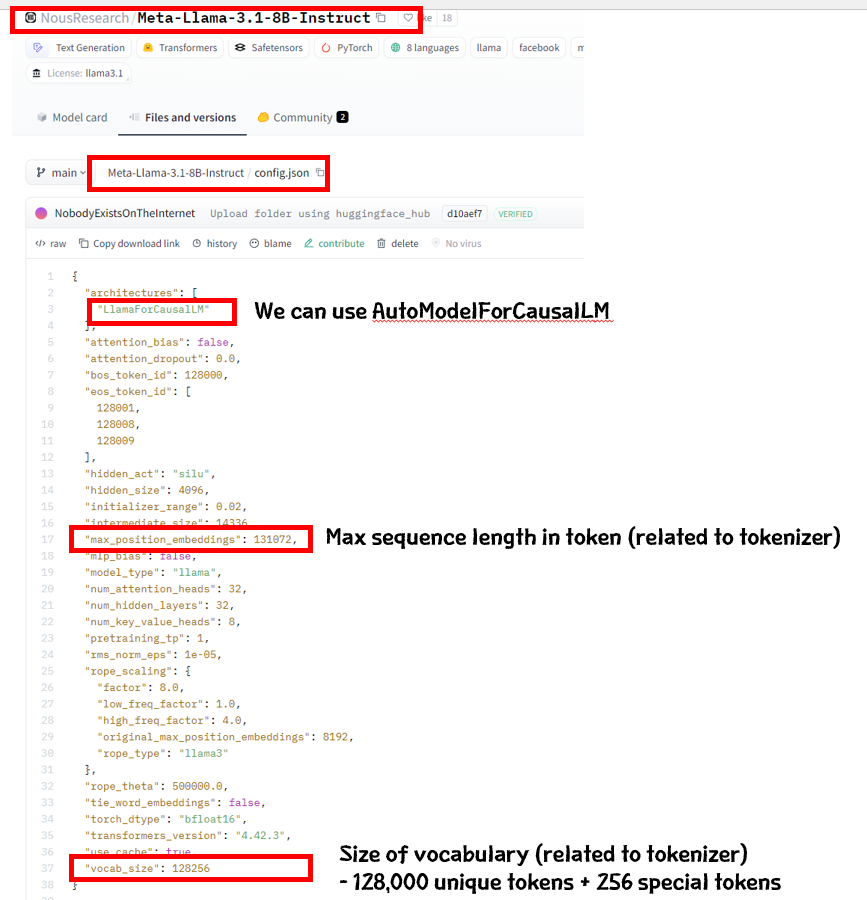

In [9]:
model_id = "NousResearch/Meta-Llama-3.1-8B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto',
)

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

##### 🚀 display tokenizer

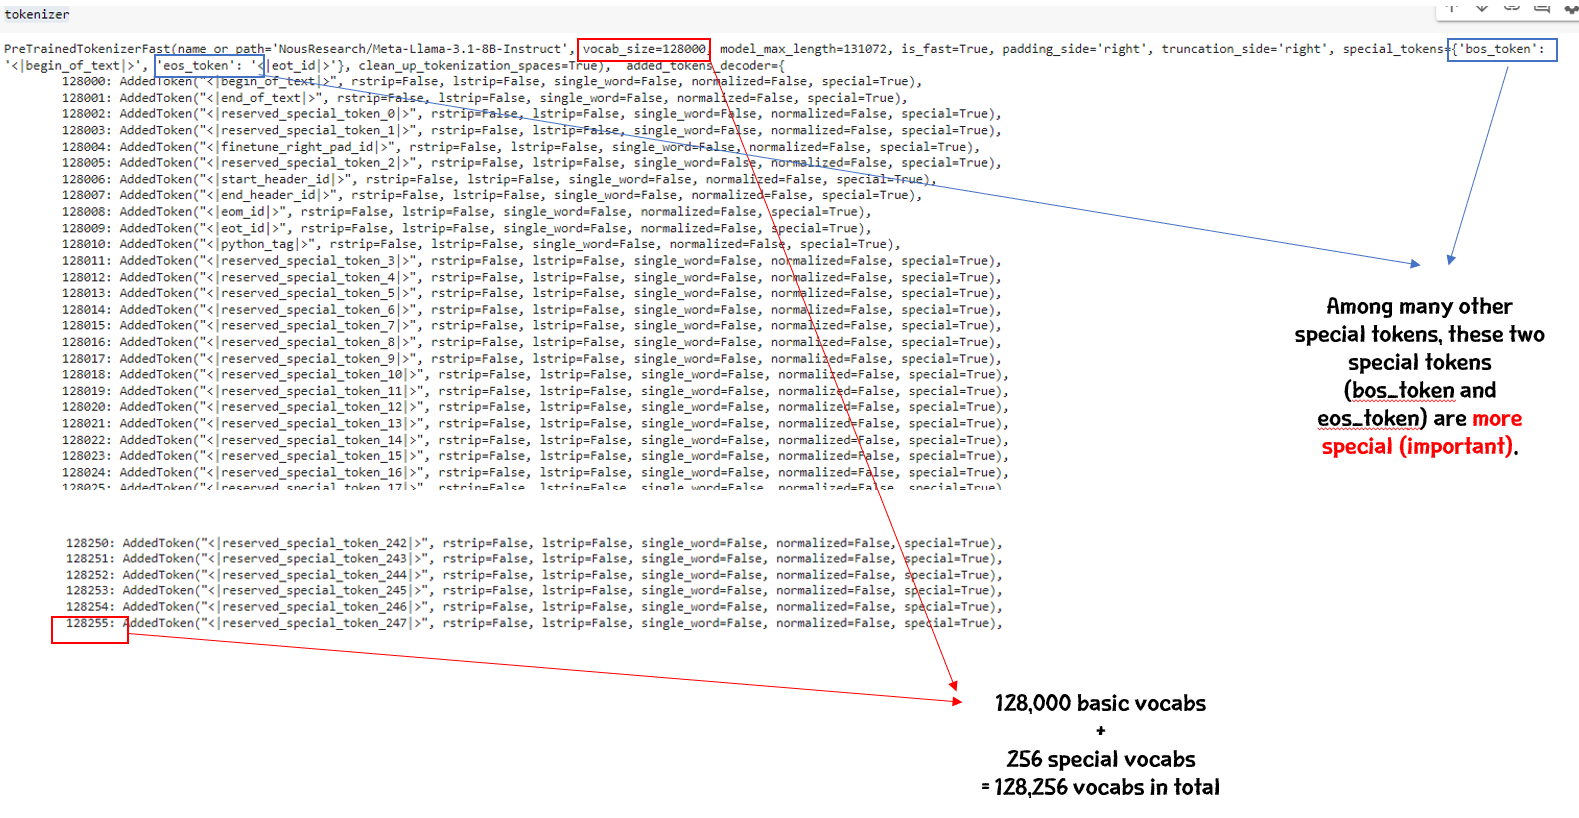

In [14]:
# 🚀 My own cell
print(tokenizer.pad_token)
print(tokenizer.padding_side)

None
right


In [15]:
tokenizer.pad_token = tokenizer.eos_token  # This is good practice for GPT-like models
tokenizer.padding_side = "right"

### Model Architecture

It's important to observe the model's construction!

This one should look familiar!

In [16]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps

In [41]:
# 🚀 My own cell
# 🚀 HuggingFace model is a wrapped version of PyTorch model.

llama3_layers = model.model.layers
print(f"type of llama-3 layers: {type(llama3_layers)}")
print('\n')
print(f"First layer: {llama3_layers[0]}")

llama3_norm = model.model.norm
print('\n')
print(f"type of llama-3 norm: {type(llama3_norm)}")

llama3_lm_head = model.lm_head
print('\n')
print(f"type of llama-3 lm_head: {type(llama3_lm_head)}")

type of llama-3 layers: <class 'torch.nn.modules.container.ModuleList'>


First layer: LlamaDecoderLayer(
  (self_attn): LlamaSdpaAttention(
    (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): LlamaRotaryEmbedding()
  )
  (mlp): LlamaMLP(
    (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
  (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
)


type of llama-3 norm: <class 'transformers.models.llama.modeling_llama.LlamaRMSNorm'>


type of llama-3 lm_head: <class '

In [55]:
# 🚀 My own cell

for name, param in llama3_layers[0].named_parameters():
    print(f"Parameter name: {name}, shape: {param.shape}, dtype: {param.dtype}")

# 🚀 Even if dtype of attention amd mlp layers is displayed as torch.unit8, it is 4bit (nf4).

Parameter name: self_attn.q_proj.weight, shape: torch.Size([8388608, 1]), dtype: torch.uint8
Parameter name: self_attn.k_proj.weight, shape: torch.Size([2097152, 1]), dtype: torch.uint8
Parameter name: self_attn.v_proj.weight, shape: torch.Size([2097152, 1]), dtype: torch.uint8
Parameter name: self_attn.o_proj.weight, shape: torch.Size([8388608, 1]), dtype: torch.uint8
Parameter name: mlp.gate_proj.weight, shape: torch.Size([29360128, 1]), dtype: torch.uint8
Parameter name: mlp.up_proj.weight, shape: torch.Size([29360128, 1]), dtype: torch.uint8
Parameter name: mlp.down_proj.weight, shape: torch.Size([29360128, 1]), dtype: torch.uint8
Parameter name: input_layernorm.weight, shape: torch.Size([4096]), dtype: torch.float16
Parameter name: post_attention_layernorm.weight, shape: torch.Size([4096]), dtype: torch.float16


In [18]:
# 🚀 model.config after actually loading the model gives more details such as quantization_config

model.config

LlamaConfig {
  "_name_or_path": "NousResearch/Meta-Llama-3.1-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false

#### ❓Question #3:

![image](https://i.imgur.com/N8y2crZ.png)

Label the image with the appropriate layer from `NousResearch/Meta-Llama-3-8B-Instruct`'s architecture.

- EXAMPLE - Layer Norm:
  - `(input_layernorm): LlamaRMSNorm()`
  - `(post_attention_layernorm): LlamaRMSNorm()`
  - `(norm): LlamaRMSNorm()`
- Feed Forward:
- Masked Multi Self-Attention:
- Text & Position Embed:
- Text Prediction:

##### 🚀 Answer to Question #3

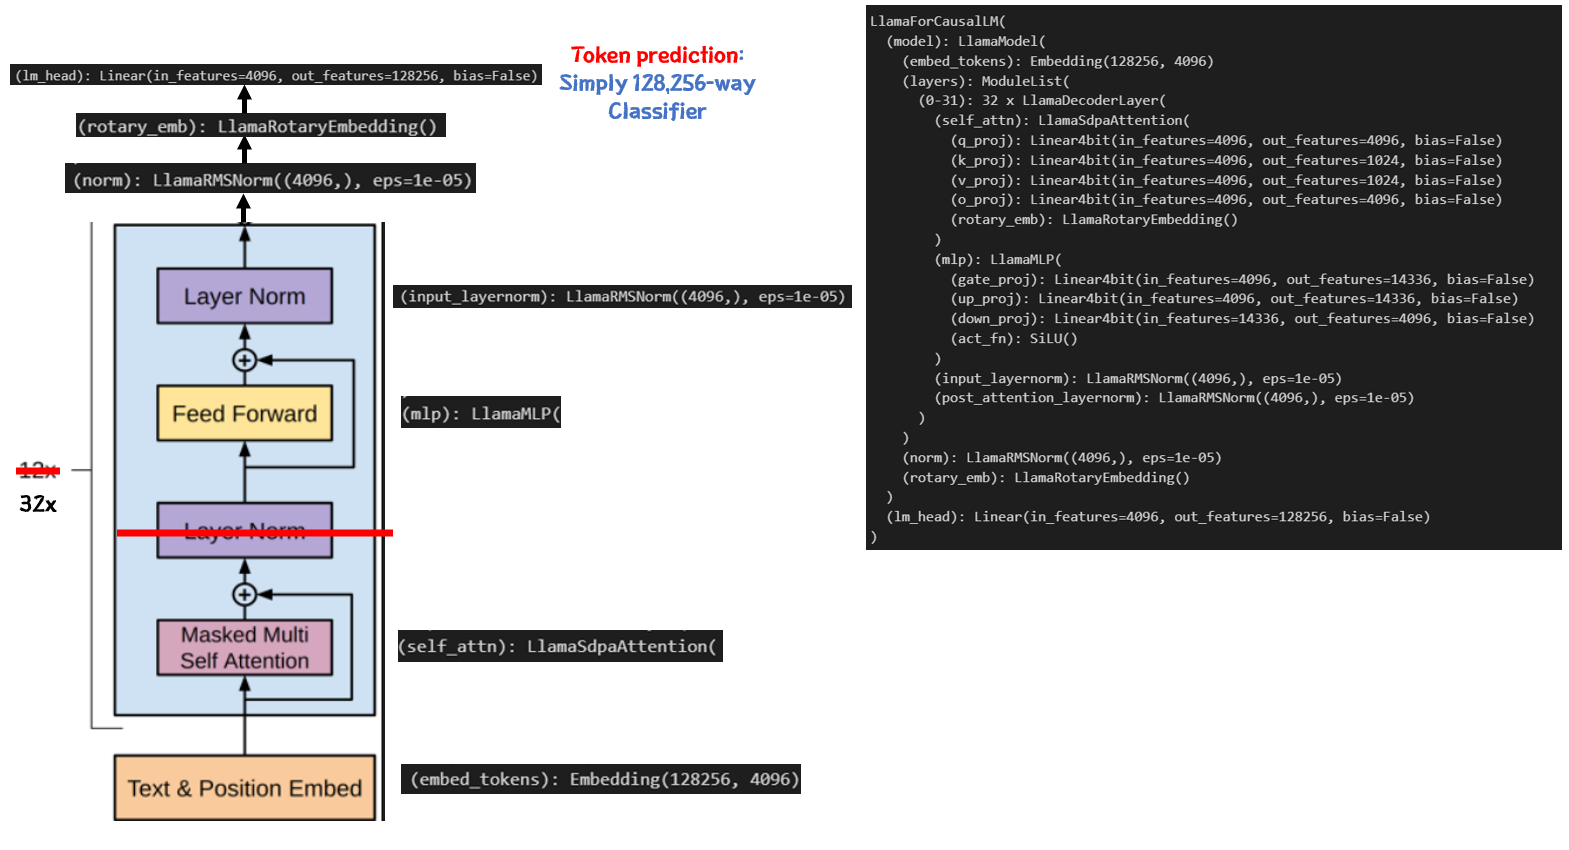

# 🤝 Breakout Room #2

## Task #2: Data and Data Preparation

Since we'll be focusing on summarization fine-tuning - we'll need to find a summarization dataset!

There are a few good examples available to use on the Hugging Face [dataset](https://huggingface.co/datasets?task_categories=task_categories:summarization&sort=trending) hub - let's check a few of them out!

> NOTE: The link above is pre-filtered to include datasets with the summarization tag

### Summarization Datasets

Let's see what is available for us:

- [`databricks/databricks-dolly-15k`](https://huggingface.co/datasets/databricks/databricks-dolly-15k)
  - this dataset is comprised of ~15K rows of various tasks of which ~7% is summarization data
- [`samsum`](https://huggingface.co/datasets/samsum)
  - this dataset contains ~16K conversations in messenger format as well as their summaries
- [`CohereForAI/aya_collection`](https://huggingface.co/datasets/CohereForAI/aya_collection)
  - similar to Dolly-15K, this dataset contains a wide range of *multilingual* tasks - a subset of which is summarization
- [`Plain English Summary of Contracts`](https://github.com/lauramanor/legal_summarization)
  - contains legal document (EULA, TOS, etc) and natural language summary pairs.

Today we'll be using the Plain English Summary of Contracts dataset to fine-tune Llama 3 8B Instruct to provide natural language descriptions of Legal Documents!

The first step will be to download the dataset from GitHub!

In [56]:
# !git clone https://github.com/lauramanor/legal_summarization

Cloning into 'legal_summarization'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 31 (delta 2), reused 0 (delta 0), pack-reused 25 (from 1)
Receiving objects: 100% (31/31), 136.60 KiB | 6.83 MiB/s, done.
Resolving deltas: 100% (10/10), done.


Then we can load it into a list of JSON objects.

In [57]:
import json

jsonl_array = []

with open('legal_summarization/tldrlegal_v1.json') as f:
  data = json.load(f)
  for key, value in data.items():
    jsonl_array.append(value)

In [62]:
# 🚀 my own cell
jsonl_array[0]

{'doc': 'Pokemon GO Terms of Service',
 'id': '5786730a6cca83a54c0035b7',
 'original_text': 'welcome to the pokémon go video game services which are accessible via the niantic inc niantic mobile device application the app. to make these pokémon go terms of service the terms easier to read our video game services the app and our websites located at http pokemongo nianticlabs com and http www pokemongolive com the site are collectively called the services. please read carefully these terms our trainer guidelines and our privacy policy because they govern your use of our services.',
 'reference_summary': 'hi.',
 'title': '',
 'uid': 'legalsum01'}

Finally we can convert our list of JSON objects to a dataset quickly and effectively using the Hugging Face [`datasets`](https://huggingface.co/docs/datasets/en/index) library!

In [63]:
from datasets import Dataset, load_dataset  # 🚀 Do not get confused with torch.utils.data.Dataset

legal_dataset = Dataset.from_list(jsonl_array)

Let's check how many items we have in each of our training, validation, and test subsets.

In [64]:
legal_dataset

Dataset({
    features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
    num_rows: 85
})

We can now format our dataset into a training test split!

In [ ]:
legal_dataset = legal_dataset.train_test_split(test_size=0.2) # 🚀 This is so handy

In [70]:
print(isinstance(legal_dataset, dict)) # 🚀 DatasetDict inherets dict

legal_dataset

True


DatasetDict({
    train: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 68
    })
    test: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 17
    })
})

In [71]:
legal_dataset_test_valid = legal_dataset["test"].train_test_split(test_size=0.5)

In [72]:
legal_dataset_test_valid

DatasetDict({
    train: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 8
    })
    test: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 9
    })
})

In [73]:
from datasets import DatasetDict

legal_dataset = DatasetDict({
    "train" : legal_dataset["train"],
    "test" : legal_dataset_test_valid["test"],
    "validation" : legal_dataset_test_valid["train"]
})

In [74]:
legal_dataset

DatasetDict({
    train: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 68
    })
    test: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 9
    })
    validation: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 8
    })
})

Let's look at a single example to see the format we're working with!

In [75]:
legal_dataset["train"][0]

{'doc': 'TLDRLegal Terms of Service',
 'id': '531ce0015d6e358722000022',
 'original_text': 'as a condition to using some features of the sites tldr may require you to register for an account create a user profile and select a user name and password. you agree to provide tldr with accurate and complete identity information including your email address and agree to update your identity information promptly if it changes. you agree not to impersonate another person falsify your identity use another user s account or otherwise take action to gain access to content to which you do not have the rights to access or use the sites in any way to which you do not have authorization. you are solely responsible for all activity that takes place under the authorization of your account. you hereby release tldr from any and all liabilities arising from such activity. you are responsible for maintaining the security of your password. you agree to promptly inform tldr if you know or suspect that your ac

### Instruction Templating

Instruction-tuned LLMs will typically use a specific template when being trained to accomodate various instruction sets, as well as for better chat and multi-turn use-cases.

Here is the format as indicated in Meta's [llama3](https://github.com/meta-llama/llama3?tab=readme-ov-file#instruction-tuned-models) repository, as well as the intuition behind the prompt template.

> The fine-tuned models were trained for dialogue applications. To get the expected features and performance for them, a specific formatting defined in ChatFormat needs to be followed: The prompt begins with a `<|begin_of_text|>` special token, after which one or more messages follow. Each message starts with the `<|start_header_id|>` tag, the role `system`, `user` or `assistant`, and the `<|end_header_id|>` tag. After a double newline `"\n\n"` the contents of the message follow. The end of each message is marked by the `<|eot_id|>` token.

Here is an example of this format:

```
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Please convert the following legal content into a human-readable summary<|eot_id|><|start_header_id|>user<|end_header_id|>

[LEGAL_DOC]
welcome to the pokémon go video game services which are accessible via the niantic inc niantic mobile device application the app. to make these pokémon go terms of service the terms easier to read our video game services the app and our websites located at http pokemongo nianticlabs com and http www pokemongolive com the site are collectively called the services. please read carefully these terms our trainer guidelines and our privacy policy because they govern your use of our services.
[END_LEGAL_DOC]<|eot_id|><|start_header_id|>assistant<|end_header_id|>

hi.<|eot_id|>
```

> NOTE: We're adding our own special tokens here in `[LEGAL_DOC]` and `[END_LEGAL_DOC]` to encourage the model to better understand our context, but these are not special tokens that are already understood by the model.

#### 🏗️ Activity #1: Creating the `create_prompt` function

We'll create a function that will take a row of our dataset, along with a default False flag that creates the prompt in the format expressed above.

In [76]:
INSTRUCTION_PROMPT_TEMPLATE = """\
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Please convert the following legal content into a short human-readable summary<|eot_id|><|start_header_id|>user<|end_header_id|>

[LEGAL_DOC]{LEGAL_TEXT}[END_LEGAL_DOC]<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

RESPONSE_TEMPLATE = """\
{NATURAL_LANGUAGE_SUMMARY}<|eot_id|><|end_of_text|>"""

In [77]:
def create_prompt(sample, include_response = True):
  """
  Parameters:
    - sample: dict representing row of dataset
    - include_response: bool

  Functionality:
    This function should build the Python str `full_prompt`.

    If `include_response` is true, it should include the summary -
    else it should not contain the summary (useful for prompting) and testing

  Returns:
    - full_prompt: str
  """
  full_prompt = INSTRUCTION_PROMPT_TEMPLATE.format(LEGAL_TEXT=sample["original_text"])

  if include_response:
    full_prompt += RESPONSE_TEMPLATE.format(NATURAL_LANGUAGE_SUMMARY=sample["reference_summary"])


  return full_prompt

In [78]:
print(create_prompt(legal_dataset["test"][1]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Please convert the following legal content into a short human-readable summary<|eot_id|><|start_header_id|>user<|end_header_id|>

[LEGAL_DOC]if you ve bought the game you may play around with it and modify it. we d appreciate it if you didn t use this for griefing though and remember not to distribute the changed versions of our software. basically mods or plugins or tools are cool you can distribute those hacked versions of the game client or server are not you can t distribute those.[END_LEGAL_DOC]<|eot_id|><|start_header_id|>assistant<|end_header_id|>you may mod the game but don t distribute hacked clients.<|eot_id|><|end_of_text|>


In [79]:
def generate_response(prompt, model, tokenizer):
  """
  Parameters:
    - prompt: str representing formatted prompt
    - model: model object
    - tokenizer: tokenizer object

  Functionality:
    This will allow our model to generate a response to a prompt!

  Returns:
    - str response of the model
  """

  # convert str input into tokenized input
  encoded_input = tokenizer(prompt,  return_tensors="pt")

  # send the tokenized inputs to our GPU
  model_inputs = encoded_input.to('cuda')

  # generate response and set desired generation parameters
  generated_ids = model.generate(
      **model_inputs,
      max_new_tokens=256,
      do_sample=True,
      pad_token_id=tokenizer.eos_token_id # 🚀 we have set tokenizer.pad_token = tokenizer.eos_token
  )

  # decode output from tokenized output to str output
  decoded_output = tokenizer.batch_decode(generated_ids)

  # return only the generated response (not the prompt) as output
  return decoded_output[0].split("<|end_header_id|>")[-1]

In [83]:
# 🚀 my own cell

prompt = create_prompt(legal_dataset["test"][1], include_response=False)
print(prompt)
print('\n')

tokenizer(prompt,  return_tensors="pt")


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Please convert the following legal content into a short human-readable summary<|eot_id|><|start_header_id|>user<|end_header_id|>

[LEGAL_DOC]if you ve bought the game you may play around with it and modify it. we d appreciate it if you didn t use this for griefing though and remember not to distribute the changed versions of our software. basically mods or plugins or tools are cool you can distribute those hacked versions of the game client or server are not you can t distribute those.[END_LEGAL_DOC]<|eot_id|><|start_header_id|>assistant<|end_header_id|>




{'input_ids': tensor([[128000, 128000, 128006,   9125, 128007,    271,   5618,   5625,    279,
           2768,   5897,   2262,   1139,    264,   2875,   3823,  84318,  12399,
         128009, 128006,    882, 128007,    271,     58,  76334,  70011,     60,
            333,    499,   5320,  11021,    279,   1847,    499,   1253,   1514,
           2212,    449,    433,    323,   5719,    433,     13,    584,    294,
          15763,    433,    422,    499,   3287,    259,   1005,    420,    369,
          38384,    287,   3582,    323,   6227,    539,    311,  16822,    279,
           5614,  11028,    315,   1057,   3241,     13,  13524,  29354,    477,
          17658,    477,   7526,    527,   7155,    499,    649,  16822,   1884,
          47939,  11028,    315,    279,   1847,   3016,    477,   3622,    527,
            539,    499,    649,    259,  16822,   1884,   8032,   4794,  73403,
            984,  70011,     60, 128009, 128006,  78191, 128007]]), 'attention_mask': tensor([[

In [84]:
generate_response(create_prompt(legal_dataset["test"][1], include_response=False),
                  model,
                  tokenizer)

"\n\nHere's a short, human-readable summary:\n\n**Using and Modifying the Game**\n\nIf you've purchased the game, you're free to play and customize it as you like. However, please don't use it to harm others (griefing) and don't distribute modified versions of the game software itself.<|eot_id|>"

In [85]:
# Ground Truth Summary
legal_dataset["test"][1]["reference_summary"]

'you may mod the game but don t distribute hacked clients.'

Let's try another just to see how the model responds to a different prompt.

In [86]:
generate_response(create_prompt(legal_dataset["test"][3], include_response=False),
                  model,
                  tokenizer)

"\n\nHere is a short human-readable summary:\n\n**Terms of Service**\n\nBy using the Google Platform, you agree to follow Google's rules:\n\n* Check out the Google Platform Developer Policies at [developers.google.com/policies](http://developers.google.com/policies) for details.\n* Ensure that any content you share, including user-supplied content, adheres to Google's User Content and Conduct Policy at [www.google.com/intl/en/policies/content.html](http://www.google.com/intl/en/policies/content.html).<|eot_id|>"

In [87]:
# Ground Truth Summary
legal_dataset["test"][3]["reference_summary"]

'you must also abide by the developer content and user content policies also.'

The response, while an accurate *recounting* of the conversation is certainly not what would be consider to be a summary.

Let's see how fine-tuning can improve these responses.

### Required Post Processing

Finally, we need to apply some post-processing on the 4-bit model to enable training, let's freeze all our layers, and cast the layer-norm in `float32` for stability. We also cast the output of the last layer in `float32` for the same reasons.

Instead of doing this manually, of course, we can use the helper function `prepare_model_for_kbit_training`! You can look at the source code [here](https://github.com/huggingface/peft/blob/18773290938fc632c42ac49f462ab34bd1abd3ea/src/peft/utils/other.py#L67)

In [89]:
from peft import prepare_model_for_kbit_training
model.config.use_cache = False   # 🚀 For training, it MUST be False
model = prepare_model_for_kbit_training(model)

## Task #3: Setting up PEFT LoRA

Here comes the magic with `peft`! Let's load a `PeftModel` and specify that we are going to use low-rank adapters (LoRA) using `get_peft_model` utility function from `peft`.

#### Helper Function to Print Parameter %age

This is just a helper function to print out just how much LoRA reduces the number of trainable parameters.

In [90]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

#### Initializing LoRA Config

There's a lot to unpack here - so let's talk about the main parameters:

- `r`: is the "rank" of the two decomposed matrices we'll be using to represent our weight matrix. In reality, this is the dimension of the decomposed matrices.

Here is an exerpt from the paper to help provide context for the selected `r`

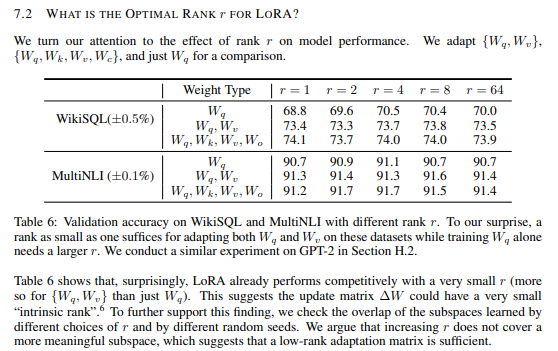


- `target_modules`: As LoRA can be applied to *any* weight matrix - we need to configure *which* module (weight matrix) it's being applied to. The LoRA paper suggests applying it to the Attention weights, but the QLoRA paper suggests we apply it to all Linear layers. Thus, we'll omit `target_module` from our hyper-parameters.


- `task_type`: This is a derived property. If you're using a causal model, this should be set to `CAUSAL_LM`. Please ensure this property is set based on your selected model.

Again, while this is the way we're leveraging LoRA in this notebook - it can be used in conjunction with many different models - and many different tasks. You can even use it for tasks like [token classification!](https://huggingface.co/docs/peft/task_guides/token-classification-lora)

In [91]:
from peft import LoraConfig, get_peft_model

# set our rank (higher value is more memory/better performance)
lora_r = 16

# set our dropout (default value)
lora_dropout = 0.1

# rule of thumb: alpha should be (lora_r * 2)
lora_alpha = 32

# construct our LoraConfig with the above hyperparameters
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM"
)

Now that we have our PEFT config - we need to convert our model into a PEFT model!

We can use the convenient helper function `get_peft_model` to do so.

Documentation found [here](https://github.com/huggingface/peft/blob/18773290938fc632c42ac49f462ab34bd1abd3ea/src/peft/mapping.py#L98)!

In [92]:
model = get_peft_model(
    model,
    peft_config
)

print_trainable_parameters(model)

trainable params: 41943040 || all params: 4582543360 || trainable%: 0.9152786281546499


In [93]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): 

#### ❓Question #4:

What modules (or groupings of layers) did we apply LoRA too - and how can we tell from the model summary?

#### 🚀 Answer to Question #4 

##### As we guided by input arguments to LoraConfig, all linear layers are the target layers of RoLA which include:
- self-attention layers: q_proj / k_proj / v_proj / o_proj  
- mlp layers: gate_proj / up_proj / down_proj

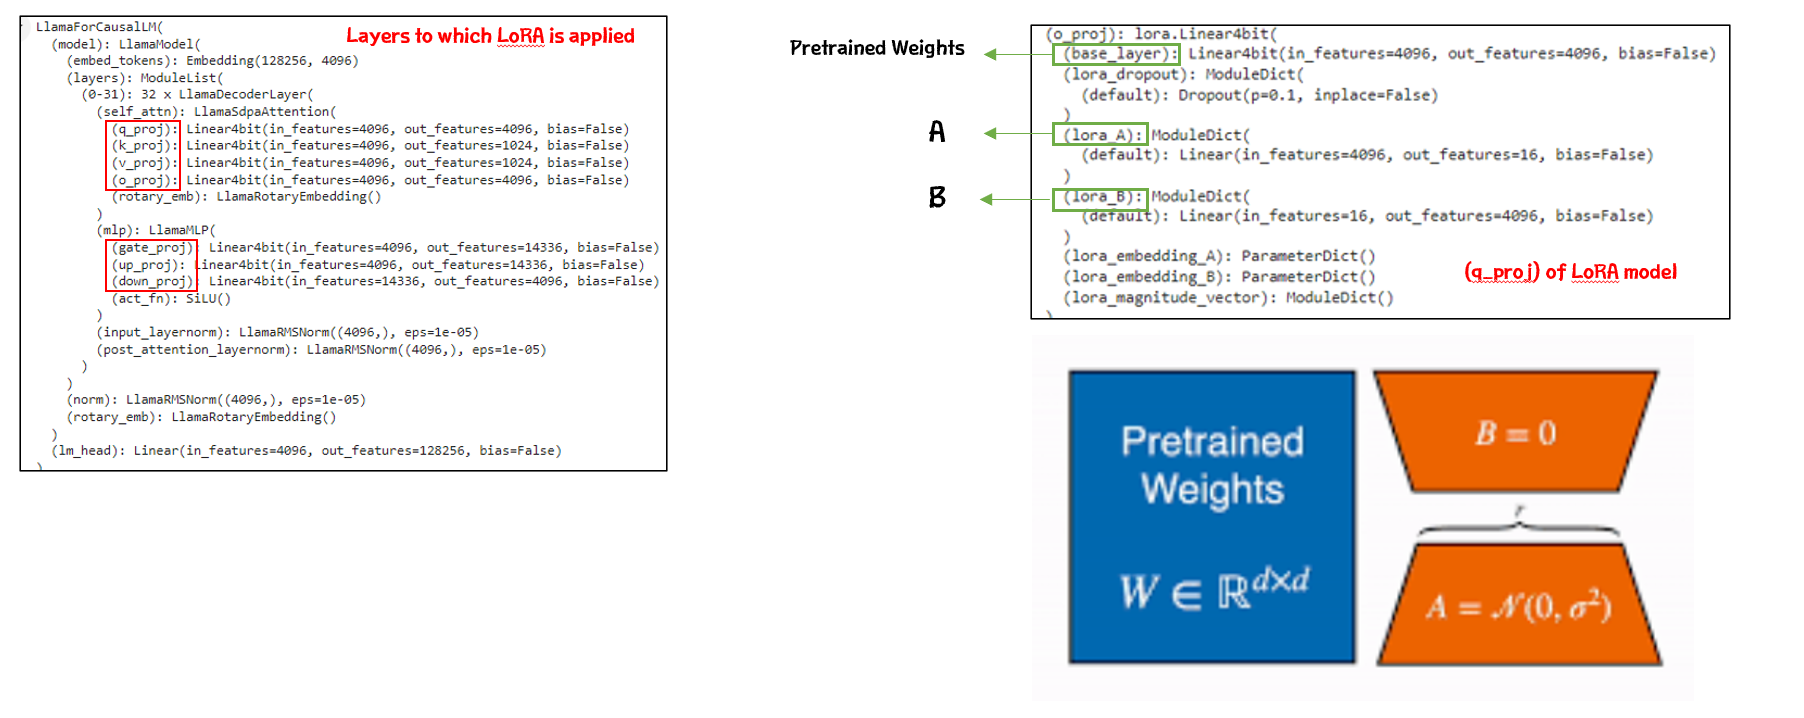

## Task #4: Training the Model

Now we'll be training our model with the created dataset!



### Setting up Training

The `SFTConfig` class contains all the usual suspects - these are the same hyper-parameters you know and love from from previous notebooks!

If you're running into CUDA memory issues - please modify both the `per_device_train_batch_size` to be lower, and also reduce `r` in your LoRAConfig. You'll need to restart and re-run your notebook after doing so.

In [94]:
from trl import SFTConfig

max_seq_length = 1024

args = SFTConfig(
  output_dir = "llama381binstruct_summarize_short",
  #num_train_epochs=5,
  max_steps = 500, # comment out this line if you want to train in epochs
  per_device_train_batch_size = 1,
  warmup_steps = 30,
  logging_steps=10,
  #evaluation_strategy="epoch",
  eval_strategy="steps",
  eval_steps=25, # comment out this line if you want to evaluate at the end of each epoch
  learning_rate=2e-4,
  lr_scheduler_type='linear',
  dataset_kwargs={
        "add_special_tokens" : False,
        "append_concat_token" : False,
  },
  max_seq_length=max_seq_length,
  packing=True,
)

#### ❓Question #5:

Describe what the following parameters are doing:

- `warmup_steps`
- `learning_rate`
- `lr_scheduler_type`

> NOTE: Feel free to consult the [documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) or other resources!

#### 🚀 Answer to Question #5 (thanks to ChatGPT)

- `warmup_steps`: warmup_steps is a hyperparameter that specifies the number of training steps for which the learning rate will gradually increase from 0 to the specified learning_rate (in this case, 2e-4).
    - The purpose of warm-up is to stabilize training by allowing the model to "ramp up" its learning rate gradually rather than starting with a high learning rate. This helps prevent divergence in the early stages of training.
    - During the warm-up phase, the learning rate typically increases linearly from 0 to the target learning rate. After the warm-up period, the learning rate can then be adjusted based on the chosen learning rate schedule (lr_scheduler_type)


- `learning_rate`: learning_rate is a hyperparameter that controls the step size of the optimization algorithm when updating the model's weights. It determines how much the weights are adjusted with respect to the loss gradient.

- `lr_scheduler_type`: lr_scheduler_type specifies the type of learning rate scheduler to use during training. The learning rate scheduler adjusts the learning rate according to a specific schedule to improve training performance.
    - The choice of learning rate scheduler affects how the model converges and can prevent overfitting or underfitting. The linear scheduler is effective for many fine-tuning tasks, as it provides a simple yet effective way to reduce the learning rate gradually as training progresses.

In [95]:
from trl import SFTTrainer

trainer = SFTTrainer(
  model=model,
  peft_config=peft_config,
  tokenizer=tokenizer,
  formatting_func=create_prompt,
  args=args,
  train_dataset=legal_dataset["train"],
  eval_dataset=legal_dataset["validation"]
)

/home/jetlee/anaconda3/envs/AIE4/lib/python3.11/site-packages/trl/trainer/utils.py:520: UserWarning: The passed formatting_func has more than one argument. Usually that function should have a single argument `example` which corresponds to the dictionary returned by each element of the dataset. Make sure you know what you are doing.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
/home/jetlee/anaconda3/envs/AIE4/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:431: UserWarning: You passed `packing=True` to the SFTTrainer/SFTConfig, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


> NOTE: The following cell should take ~45min. or so to complete on a T4 GPU with the pre-set hyper-parameters.

In [ ]:
trainer.train()

#### 🚀 I trained it on Colab. Here is the result
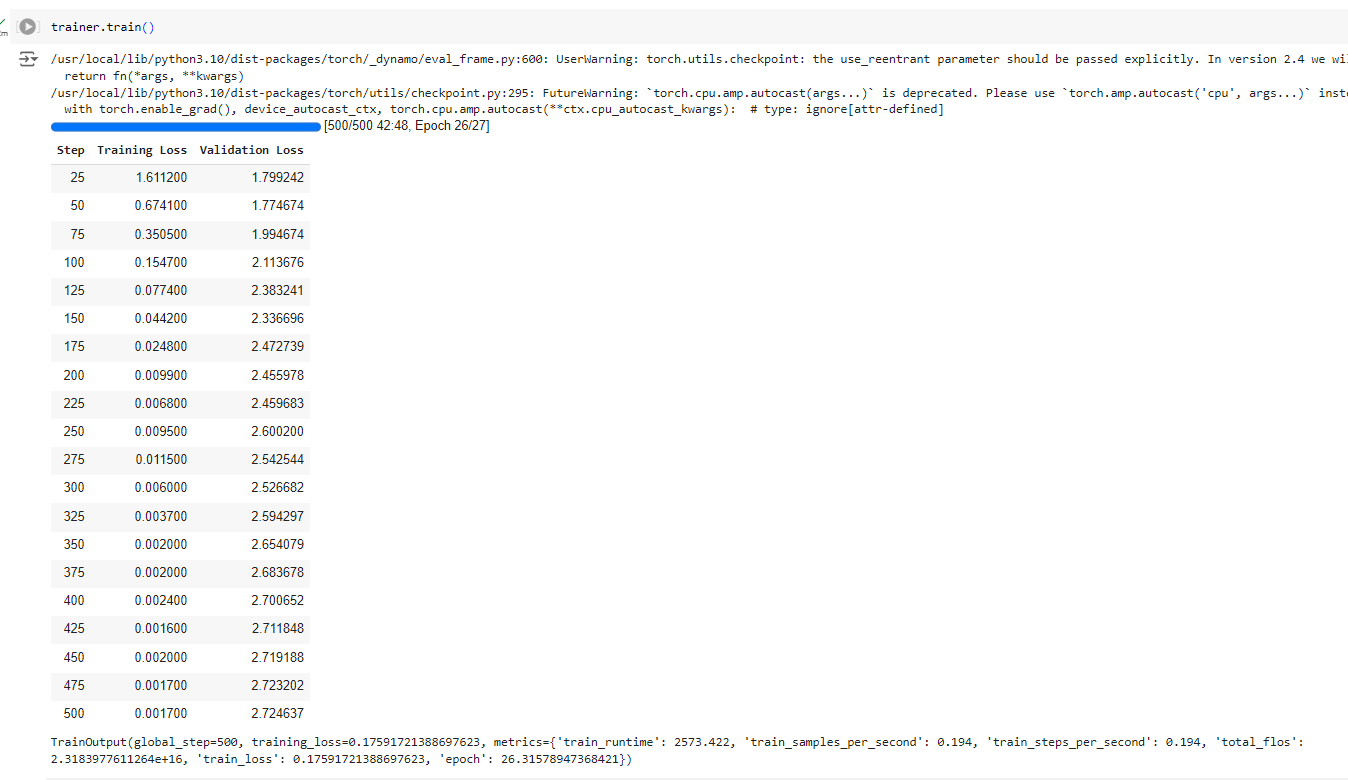


## Task #5: Share Your Model!

Normally, we would only seek to push the LoRA adapters to the hub. This is a lightweight and memory efficient way to push this model - as you can pull the base model down as part of the inference pipeline.

However, if you want to leverage the one-click-deploy features of Hugging Face, you'll need to first `merge_and_unload()` the model and push the resulting model to the hub. This process will merge the LoRA weights back into the base model.

> NOTE: If you run into issues during upload - please ensure you're using a HF Token with `WRITE` access!

In [105]:
# from huggingface_hub import notebook_login

# notebook_login()

In [100]:
# trainer.push_to_hub("jet-taekyo/llama381binstruct_summarize_short")

### Compare Outputs

Let's see how our model fairs at this task, now!

In [40]:
# merged_model = model.merge_and_unload()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:336: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


#### ❓Question #6:

What does the `merge_and_unload()` method do?

> NOTE: Check out the [documentation](https://huggingface.co/docs/trl/v0.7.11/use_model) or the [source code](https://github.com/huggingface/peft/blob/096fe537370cf8a2cb55cc9bd05c7812ca919405/src/peft/tuners/lora/model.py#L685) to find out!

#### 🚀 Answer to #6

The merge_and_unload() method in the LoraModel class is designed to merge the LoRA (Low-Rank Adaptation) layers back into the base model and unload the adapted layers, effectively returning the base model with the applied adaptations.

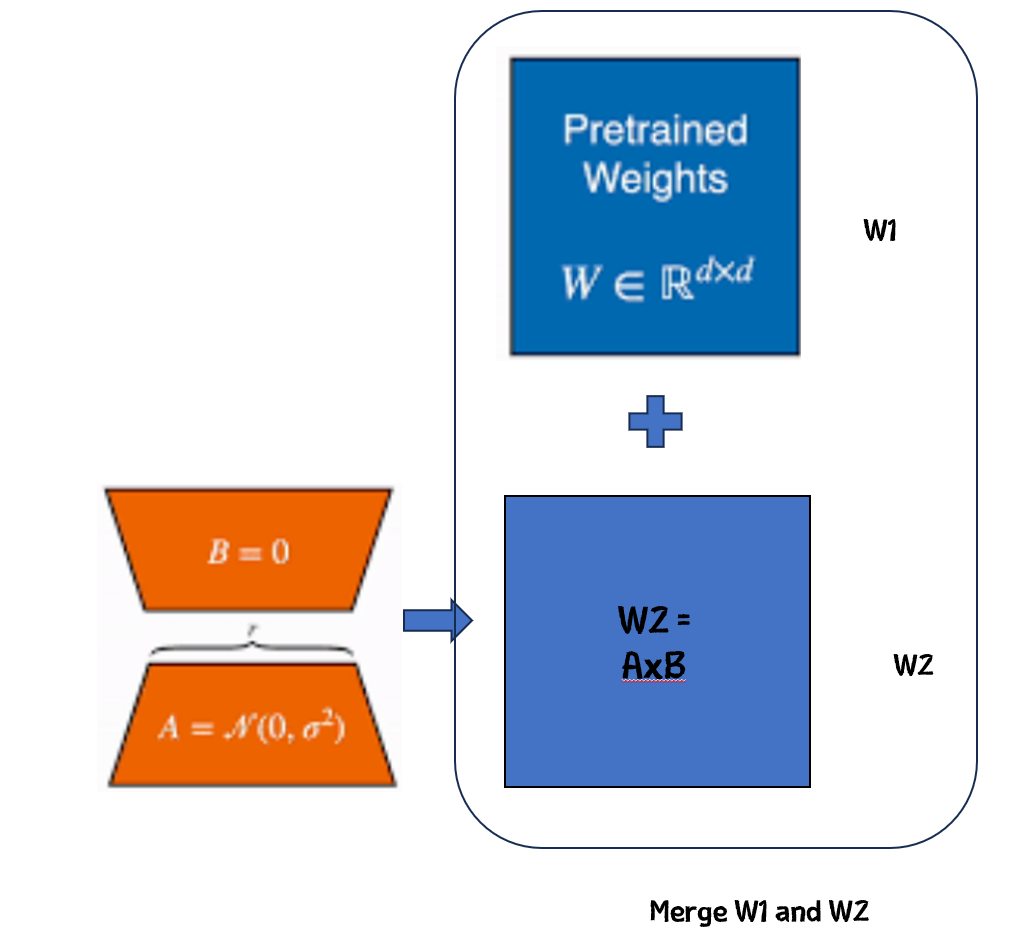

In [101]:
# 🚀 My own cell
# 🚀 Load the LoRA adaptor I have trained on Colab and merge it into base model.

from peft import PeftModel

lora_model_id = "jet-taekyo/llama381binstruct_summarize_short"

# Apply the LoRA adapter to the base model
merged_model = PeftModel.from_pretrained(model, lora_model_id)
merged_model = model.merge_and_unload()

adapter_config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

In [104]:
# 🚀 My own cell
print(merged_model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps

In [111]:
# 🚀 My own cell
response1_basemodel = "\n\nHere's a short, human-readable summary:\n\n**Using and Modifying the Game**\n\nIf you've purchased the game, you're free to play and customize it as you like. However, please don't use it to harm others (griefing) and don't distribute modified versions of the game software itself.<|eot_id|>"
response3_basemodel = "\n\nHere is a short human-readable summary:\n\n**Terms of Service**\n\nBy using the Google Platform, you agree to follow Google's rules:\n\n* Check out the Google Platform Developer Policies at [developers.google.com/policies](http://developers.google.com/policies) for details.\n* Ensure that any content you share, including user-supplied content, adheres to Google's User Content and Conduct Policy at [www.google.com/intl/en/policies/content.html](http://www.google.com/intl/en/policies/content.html).<|eot_id|>"

In [109]:
response1_finetuned_model = generate_response(create_prompt(legal_dataset["test"][1], include_response=False),
                  merged_model,
                  tokenizer)

In [121]:
# 🚀 My own cell
print(f"-- original text --")
print(legal_dataset["test"][1]["original_text"].strip())
print('\n')

print(f"-- Ground Truth summary --")
print(legal_dataset["test"][1]["reference_summary"].strip())
print('\n')

print(f"-- base model summary --")
print(response1_basemodel.strip())
print('\n')

print(f"-- fine-tuned model summary--")
print(response1_finetuned_model.strip())


-- original text --
if you ve bought the game you may play around with it and modify it. we d appreciate it if you didn t use this for griefing though and remember not to distribute the changed versions of our software. basically mods or plugins or tools are cool you can distribute those hacked versions of the game client or server are not you can t distribute those.


-- Ground Truth summary --
you may mod the game but don t distribute hacked clients.


-- base model summary --
Here's a short, human-readable summary:

**Using and Modifying the Game**

If you've purchased the game, you're free to play and customize it as you like. However, please don't use it to harm others (griefing) and don't distribute modified versions of the game software itself.<|eot_id|>


-- fine-tuned model summary--
Here is a short human-readable summary:

**Modifying the Game:**

* You can play with and modify the game as you like after purchasing it.
* We appreciate it if you don't use mods for malicious pu

Let's look at the base model response:

> **Using YouTube Content**\n\nYou can access YouTube content for personal, non-commercial use through the website or app. You can only download content if a "download" link is provided by YouTube. You need permission from YouTube or the content owner to:\n\n* Copy, reproduce, distribute, transmit, broadcast, display, sell, or license content for any other purpose.\n* Use content for any purpose other than personal, non-commercial use.\n\nYouTube and its owners retain all rights not explicitly granted in the terms of service.

Now the fine-tuned response:

> **Using YouTube Content**\n\n* You can access and use YouTube content for personal use and as intended by the service.\n* You can only download content if a download link is explicitly provided by YouTube.\n* You need permission from YouTube or the content owner to use, copy, reproduce, distribute, or sell content for any purpose other than personal use.



We can see that, directionally, our model is getting much closer to our desired results with only *100* steps of training.

Let's try another example to make sure it wasn't a fluke!

In [125]:
# legal_dataset["test"][3]["original_text"]

'you agree to comply with the google platform developer policies set forth athttp developers google com policies and the google play content policies set forth at http play google com about developer content policy html or other such urls as google may provide for this purpose from time to time the content of your api client including any content supplied by your users or other content providers must follow the google user content and conduct policy at http www google com intl en policy content html.'

In [122]:
response3_finetuned_model = generate_response(create_prompt(legal_dataset["test"][3], include_response=False),
                  merged_model,
                  tokenizer)

In [124]:
# # Ground Truth Summary
# legal_dataset["test"][3]["reference_summary"]

'you must also abide by the developer content and user content policies also.'

In [123]:
# 🚀 My own cell
print(f"-- original text --")
print(legal_dataset["test"][3]["original_text"].strip())
print('\n')

print(f"-- Ground Truth summary --")
print(legal_dataset["test"][3]["reference_summary"].strip())
print('\n')

print(f"-- base model summary --")
print(response3_basemodel.strip())
print('\n')

print(f"-- fine-tuned model summary--")
print(response3_finetuned_model.strip())


-- original text --
you agree to comply with the google platform developer policies set forth athttp developers google com policies and the google play content policies set forth at http play google com about developer content policy html or other such urls as google may provide for this purpose from time to time the content of your api client including any content supplied by your users or other content providers must follow the google user content and conduct policy at http www google com intl en policy content html.


-- Ground Truth summary --
you must also abide by the developer content and user content policies also.


-- base model summary --
Here is a short human-readable summary:

**Terms of Service**

By using the Google Platform, you agree to follow Google's rules:

* Check out the Google Platform Developer Policies at [developers.google.com/policies](http://developers.google.com/policies) for details.
* Ensure that any content you share, including user-supplied content, adh

Lets look at the base model response:

>  **Permission to Use Your Content**\n\nWhen you create content for our game, you grant us permission to:\n\n* Use your content as we see fit\n* Make copies of your content\n* Modify or adapt your content\n* Allow others to use, copy, modify, or adapt your content\n\nIf you don't want to give us this permission, don't create content for our game.

And the fine-tuned model:

> **Permission for Game Content**\n\nWhen you share content on our game, you agree to let us:\n\n* Use, modify, and adapt your content\n* Allow others to use, modify, and adapt your content\n* This permission is permanent and can't be taken back\n* Consider carefully before sharing content, as it will be public and may be used in ways you don't like.

And again, we can see that the model performs the task *better* than the original un-fine-tuned model, in that the language is less formal - though there is still work to do.